In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
import pandas as pd
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import cv2
from keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
tf.__version__

'2.7.0'

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import *
from keras import models 

In [3]:
df_train = pd.read_pickle("./train_data.pkl")
df_train.shape

(5216, 2)

In [4]:
df_valid = pd.read_pickle("./valid_data.pkl")
print('df_valid: ',df_valid.shape)
df_test = pd.read_pickle("./test_data.pkl")
print('df_test: ',df_test.shape)

df_valid:  (16, 2)
df_test:  (624, 2)


In [5]:
df_train['shape'] = df_train['matrix'].apply(lambda x: len(x.shape))

In [6]:
df_train.head()

,label,matrix,shape
0,0,"[[61, 63, 69, 75, 86, 85, 92, 89, 93, 96, 93, ...",2
1,1,"[[51, 53, 52, 52, 57, 55, 60, 61, 62, 62, 60, ...",2
2,1,"[[19, 20, 22, 27, 28, 30, 36, 40, 42, 46, 50, ...",2
3,0,"[[12, 12, 13, 13, 15, 14, 15, 16, 15, 12, 16, ...",2
4,1,"[[3, 3, 3, 2, 4, 13, 23, 25, 32, 43, 66, 64, 7...",2


In [7]:
x = df_train[df_train['shape'] ==3].iloc[0,1]

In [8]:
df_train.loc[df_train['shape'] ==3, 'matrix'] = df_train['matrix'].apply(lambda x: x.T[0].T)

In [9]:
X_test = df_test['matrix'].values
X_test = np.array([X_test[i] for i in range(X_test.shape[0])])/255.
X_test.shape

(624, 224, 224)

In [10]:
X_test = np.stack((X_test,)*3, axis=-1)
X_test.shape

(624, 224, 224, 3)

In [11]:
y_test = df_test.label.values

In [12]:
X_train = df_train['matrix'].values
X_train.shape

(5216,)

In [13]:
X_train = np.array([X_train[i] for i in range(X_train.shape[0])])
X_train.shape

(5216, 224, 224)

In [14]:
X_train = np.stack((X_train,)*3, axis=-1)
X_train.shape

(5216, 224, 224, 3)

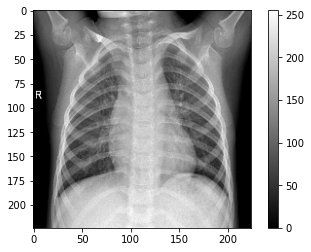

In [15]:
plt.figure()
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.grid(False)
plt.show()

In [16]:
num_classes = 2
y_train = df_train.label.values
# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_train.shape

(5216, 2)

In [17]:
X_train.shape, y_train.shape

((5216, 224, 224, 3), (5216, 2))

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [19]:
X_train.shape, y_train.shape

((4172, 224, 224, 3), (4172, 2))

In [21]:
datagen = ImageDataGenerator(rescale=1/255,
                             rotation_range=20,
                             horizontal_flip=True,
                             height_shift_range=0.1,
                             width_shift_range=0.1,
                             shear_range=0.1,
                             brightness_range=[0.3, 1.5])

In [22]:
train_gen = datagen.flow(X_train,y_train)

#Keras Applications Available models
https://keras.io/api/applications/

In [23]:
from keras.applications.resnet_v2 import ResNet50V2

ResNet = ResNet50V2(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224, 3))



In [24]:
layers_names_list = []
for layer in ResNet.layers:
    layers_names_list.append(layer.name)

In [25]:
 # If we do not want to train the resnet at all
ResNet.trainable = False

for layer in ResNet.layers:
    if layer.name in layers_names_list[:28]:
        layer.trainable = True
    else:
        layer.trainable = False       

In [26]:
ResNet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [27]:
input_shape=(224, 224, 3)

In [29]:
#num_classes = 2
model = Sequential()
model.add(ResNet)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(num_classes, activation = 'softmax'))

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               12845184  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 36,410,754
Trainable params: 12,845,698
Non-trainable params: 23,565,056
_________________________________

In [32]:
batch_size = 16
epochs = 50
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [33]:
history = model.fit(train_gen, batch_size=batch_size, epochs=epochs,validation_data=(X_valid, y_valid))

Epoch 1/50
131/131 [==============================] - 131s 931ms/step - loss: 0.4068 - accuracy: 0.8343 - val_loss: 247.0684 - val_accuracy: 0.2778
Epoch 2/50
131/131 [==============================] - 136s 1s/step - loss: 0.1887 - accuracy: 0.9261 - val_loss: 146.4480 - val_accuracy: 0.2826
Epoch 3/50
131/131 [==============================] - 130s 992ms/step - loss: 0.1473 - accuracy: 0.9431 - val_loss: 20.9730 - val_accuracy: 0.4435
Epoch 4/50
131/131 [==============================] - 137s 1s/step - loss: 0.1359 - accuracy: 0.9486 - val_loss: 37.2527 - val_accuracy: 0.3218
Epoch 5/50
131/131 [==============================] - 138s 1s/step - loss: 0.1237 - accuracy: 0.9470 - val_loss: 32.8750 - val_accuracy: 0.3745
Epoch 6/50
131/131 [==============================] - 136s 1s/step - loss: 0.1176 - accuracy: 0.9551 - val_loss: 20.1760 - val_accuracy: 0.4406
Epoch 7/50
131/131 [==============================] - 134s 1s/step - loss: 0.1051 - accuracy: 0.9616 - val_loss: 10.5916 - val_a

In [35]:
model.save("model_transfer_Resnet")
np.save('model_transfer_Resnet_history.npy',history.history)

INFO:tensorflow:Assets written to: model_transfer_Resnet\assets


In [18]:
load_history=np.load('model_transfer_Resnet_history.npy',allow_pickle='TRUE').item()
reconstructed_model = load_model("model_transfer_Resnet")
reconstructed_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                        

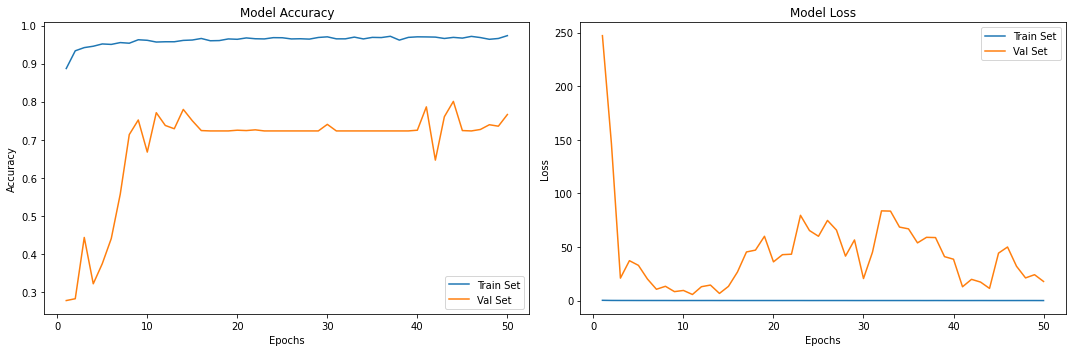

In [19]:
# plot model performance
acc = load_history['accuracy']
val_acc = load_history['val_accuracy']
loss = load_history['loss']
val_loss = load_history['val_loss']
epochs_range = range(1, len(load_history['loss']) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [38]:
#List of metric for classiffication models
def metrics_classific(y, predicted, proba_predictions):
    from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, f1_score, auc
    from matplotlib import pyplot
    confusion_matrix = confusion_matrix(y, predicted)
    print(confusion_matrix)
    print(classification_report(y, predicted))
    
    # keep probabilities for the positive outcome only
    lr_probs = proba_predictions[:, 1]
    
    # calculate precision and recall for each threshold
    lr_precision, lr_recall, _ = precision_recall_curve(y, lr_probs)

    # calculate scores
    lr_f1, lr_auc = f1_score(y, predicted), auc(lr_recall, lr_precision)

    # summarize scores
    print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

    #plot the precision-recall curves
    no_skill = len(y[y == 1]) / len(y)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [42]:
X_train.shape

(4172, 224, 224, 3)

[[170  64]
 [ 12 378]]
              precision    recall  f1-score   support

           0       0.93      0.73      0.82       234
           1       0.86      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.85      0.86       624
weighted avg       0.88      0.88      0.87       624

Logistic: f1=0.909 auc=0.969


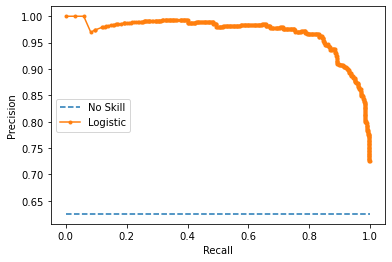

In [54]:
proba_predictions = reconstructed_model.predict(X_test)
predictions = (proba_predictions[:,1] >=0.75).astype(int)

y_test = df_test.label.values

metrics_classific(y_test, predictions, proba_predictions)